## 목적 : CutMix 또는 Mixup 비교실험 하기

### 데이터 불러오기

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print('=3')

=3


In [2]:
# 데이터 셋 불러오기
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
print('=3')

=3


In [3]:
# 데이터 label 갯수 확인
num_classes = ds_info.features["label"].num_classes
print('class 개수 :', num_classes)

class 개수 : 120


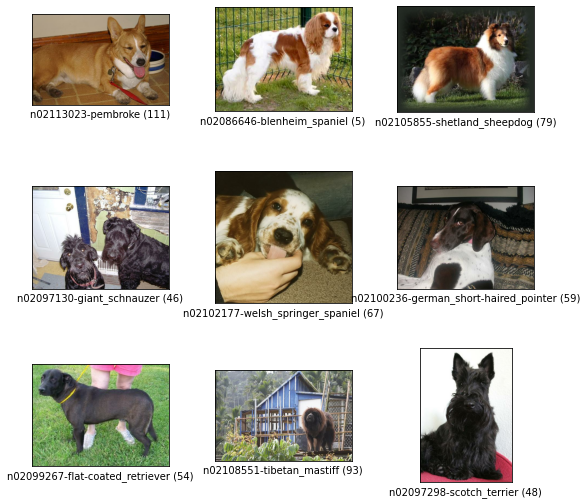

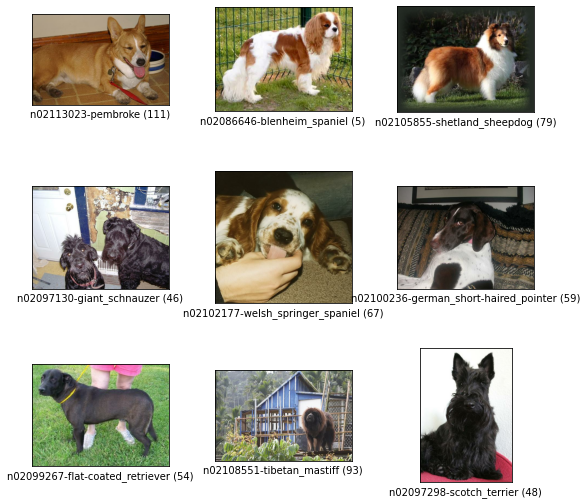

In [4]:
# 데이터 확인
tfds.show_examples(ds_train, ds_info)

### 전처리

In [5]:
# 기본적인 전처리 함수
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

# 기본적인 augmentation 함수
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

# label 원핫 인코딩 함수
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

# 전체 데이터 셋에 대해 정규화 및 전처리 함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img,  # 정규화 및 이미지 resize
        num_parallel_calls=2
    )
    if not is_test and with_aug:  # 기본 augmentation
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:  # cutmix augmentation
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:  # mixup augmentation
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,  # label onehot
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('=3')

=3


In [6]:
# Augmentation 적용하지 않은 데이터셋 생성
ds_train_no_aug = apply_normalize_on_dataset(ds_train)
ds_test_no_aug  = apply_normalize_on_dataset(ds_test, is_test=True)

In [7]:
# 기본 Augmentation 적용한 데이터셋 생성
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test_aug  = apply_normalize_on_dataset(ds_test, is_test=True)

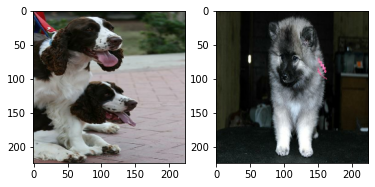

In [8]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [9]:
# 바운딩 박스의 위치를 결정하는 함수
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(42, shape=(), dtype=int32) tf.Tensor(214, shape=(), dtype=int32)
y :  tf.Tensor(96, shape=(), dtype=int32) tf.Tensor(198, shape=(), dtype=int32)


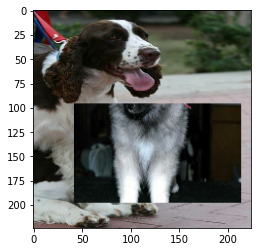

In [10]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

In [11]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.6503508 , 0.        , 0.        , 0.        ,
       0.     

In [12]:
# 위의 함수들을 활용하여 배치 단위의 함수 구현
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


In [13]:
# CutMix Augmentation 적용한 데이터셋 생성
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True) 
ds_test_cutmix = apply_normalize_on_dataset(ds_test, is_test=True) 

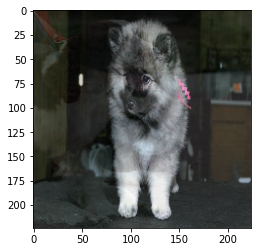

tf.Tensor(
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.2010088 0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.      

In [14]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [15]:
# 위에서 구현한 함수를 활용하여 배치 단위의 함수 구현
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


In [16]:
# MixUp Augmentation 적용한 데이터셋 생성
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True) 
ds_test_mixup = apply_normalize_on_dataset(ds_test, is_test=True) 


### 모델 생성

In [17]:
EPOCH = 20
BATCH_SIZE = 16

In [18]:
# Augmentation을 적용하지 않은 데이터셋으로 학습시킬 ResNet
resnet50_no_aug = keras.models.Sequential([
    # ResNet50 중 imagenet에 훈련된 모델을 불러오기
    keras.applications.resnet.ResNet50(
        include_top=False,    # fully connected layer를 포함하지 않음
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    # fully connected layer 추가
    keras.layers.Dense(num_classes, activation = 'softmax')
])

# Augmentation 적용하지 않은 경우
resnet50_no_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [19]:
# Augmentation을 적용한 데이터셋으로 학습시킬 ResNet
resnet50_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

# 기본 Augmentation 적용한 경우
resnet50_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [20]:
# CutMix Augmentation을 적용한 데이터셋으로 학습시킬 ResNet
resnet50_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

# CutMix Augmentation 적용한 경우
resnet50_cutmix.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [21]:
# MixUp Augmentation을 적용한 데이터셋으로 학습시킬 ResNet
resnet50_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

# MixUp Augmentation 적용한 경우
resnet50_mixup.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

### 모델 훈련

In [22]:
# Augmentation 적용하지 않은 경우
history_resnet50_no_aug = resnet50_no_aug.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test_no_aug,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 101s 122ms/step - loss: 2.2043 - accuracy: 0.4483 - val_loss: 3.3361 - val_accuracy: 0.2030
Epoch 2/20
750/750 [==============================] - 90s 120ms/step - loss: 0.6733 - accuracy: 0.8208 - val_loss: 1.0333 - val_accuracy: 0.6927
Epoch 3/20
750/750 [==============================] - 91s 121ms/step - loss: 0.1810 - accuracy: 0.9677 - val_loss: 0.9267 - val_accuracy: 0.7276
Epoch 4/20
750/750 [==============================] - 90s 120ms/step - loss: 0.0483 - accuracy: 0.9973 - val_loss: 0.8975 - val_accuracy: 0.7375
Epoch 5/20
750/750 [==============================] - 90s 120ms/step - loss: 0.0196 - accuracy: 0.9998 - val_loss: 0.9109 - val_accuracy: 0.7380
Epoch 6/20
750/750 [==============================] - 90s 120ms/step - loss: 0.0131 - accuracy: 1.0000 - val_loss: 0.9195 - val_accuracy: 0.7380
Epoch 7/20
750/750 [==============================] - 90s 120ms/step - loss: 0.0097 - accuracy: 1.0000 - val_loss: 0.9274 - val_a

In [23]:
# 기본 Augmentation 적용한 경우
history_resnet50_aug = resnet50_aug.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test_aug,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 100s 121ms/step - loss: 2.2879 - accuracy: 0.4247 - val_loss: 2.7851 - val_accuracy: 0.3032
Epoch 2/20
750/750 [==============================] - 90s 120ms/step - loss: 0.9265 - accuracy: 0.7347 - val_loss: 1.1616 - val_accuracy: 0.6611
Epoch 3/20
750/750 [==============================] - 94s 125ms/step - loss: 0.4978 - accuracy: 0.8627 - val_loss: 1.1050 - val_accuracy: 0.6834
Epoch 4/20
750/750 [==============================] - 90s 120ms/step - loss: 0.2590 - accuracy: 0.9396 - val_loss: 1.0145 - val_accuracy: 0.7011
Epoch 5/20
750/750 [==============================] - 90s 120ms/step - loss: 0.1226 - accuracy: 0.9793 - val_loss: 1.1570 - val_accuracy: 0.6790
Epoch 6/20
750/750 [==============================] - 94s 126ms/step - loss: 0.0729 - accuracy: 0.9893 - val_loss: 0.9431 - val_accuracy: 0.7364
Epoch 7/20
750/750 [==============================] - 95s 126ms/step - loss: 0.0432 - accuracy: 0.9955 - val_loss: 1.0180 - val_a

In [24]:
# CutMix Augmentation 적용한 경우
history_resnet50_cutmix = resnet50_cutmix.fit(
    ds_train_cutmix, # CutMix augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test_cutmix,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 101s 123ms/step - loss: 3.8304 - accuracy: 0.2107 - val_loss: 3.7024 - val_accuracy: 0.1617
Epoch 2/20
750/750 [==============================] - 91s 121ms/step - loss: 2.9438 - accuracy: 0.4358 - val_loss: 1.2955 - val_accuracy: 0.6330
Epoch 3/20
750/750 [==============================] - 91s 121ms/step - loss: 2.6260 - accuracy: 0.5381 - val_loss: 1.2771 - val_accuracy: 0.6476
Epoch 4/20
750/750 [==============================] - 91s 121ms/step - loss: 2.4534 - accuracy: 0.5865 - val_loss: 1.1938 - val_accuracy: 0.6659
Epoch 5/20
750/750 [==============================] - 91s 121ms/step - loss: 2.2947 - accuracy: 0.6389 - val_loss: 1.1990 - val_accuracy: 0.6761
Epoch 6/20
750/750 [==============================] - 91s 121ms/step - loss: 2.1489 - accuracy: 0.6842 - val_loss: 1.5198 - val_accuracy: 0.5956
Epoch 7/20
750/750 [==============================] - 91s 121ms/step - loss: 2.0424 - accuracy: 0.7236 - val_loss: 1.1314 - val_a

In [25]:
# MixUp Augmentation 적용한 경우
history_resnet50_mixup = resnet50_mixup.fit(
    ds_train_mixup, # MixUp augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test_mixup,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 101s 123ms/step - loss: 3.7275 - accuracy: 0.2412 - val_loss: 3.9265 - val_accuracy: 0.1433
Epoch 2/20
750/750 [==============================] - 91s 122ms/step - loss: 2.8507 - accuracy: 0.4753 - val_loss: 1.5720 - val_accuracy: 0.5703
Epoch 3/20
750/750 [==============================] - 91s 122ms/step - loss: 2.5647 - accuracy: 0.5849 - val_loss: 1.3434 - val_accuracy: 0.6240
Epoch 4/20
750/750 [==============================] - 92s 122ms/step - loss: 2.3904 - accuracy: 0.6550 - val_loss: 1.3416 - val_accuracy: 0.6288
Epoch 5/20
750/750 [==============================] - 92s 122ms/step - loss: 2.2659 - accuracy: 0.7006 - val_loss: 1.2659 - val_accuracy: 0.6561
Epoch 6/20
750/750 [==============================] - 91s 122ms/step - loss: 2.1486 - accuracy: 0.7474 - val_loss: 1.3881 - val_accuracy: 0.6266
Epoch 7/20
750/750 [==============================] - 92s 123ms/step - loss: 2.0714 - accuracy: 0.7726 - val_loss: 1.3147 - val_a

### 시각화

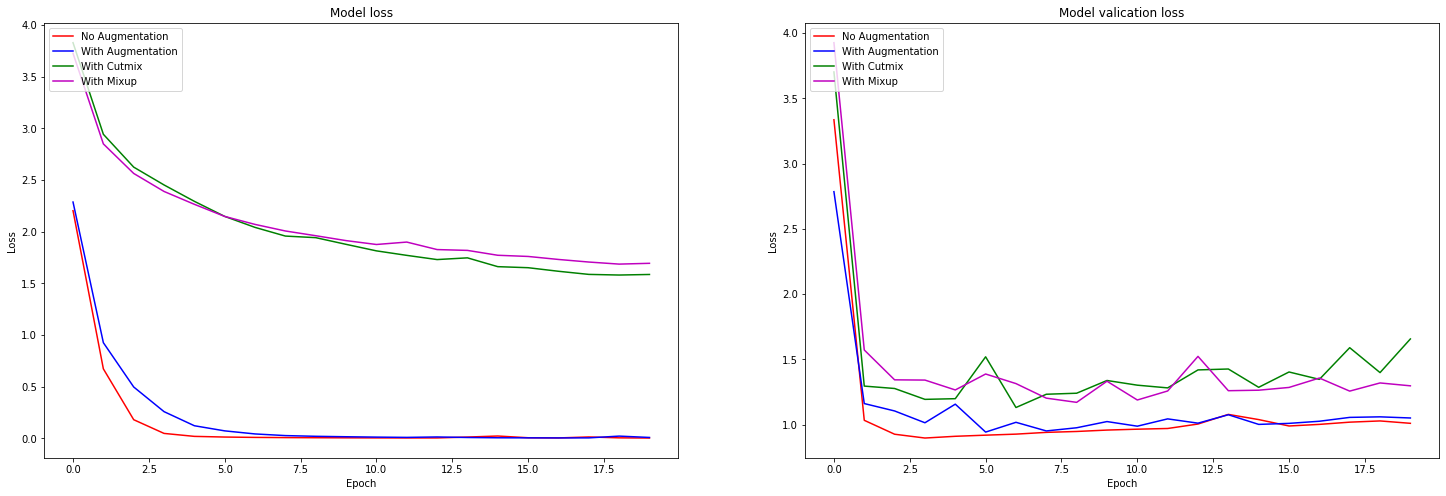

In [26]:
# 훈련 과정 시각화
fig = plt.figure(figsize=(25,8))

plt.subplot(1, 2, 1)
plt.plot(history_resnet50_no_aug.history['loss'], 'r')
plt.plot(history_resnet50_aug.history['loss'], 'b')
plt.plot(history_resnet50_cutmix.history['loss'], 'g')
plt.plot(history_resnet50_mixup.history['loss'], 'm')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix', 'With Mixup'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'g')
plt.plot(history_resnet50_mixup.history['val_loss'], 'm')
plt.title('Model valication loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix', 'With Mixup'], loc='upper left')
plt.show()

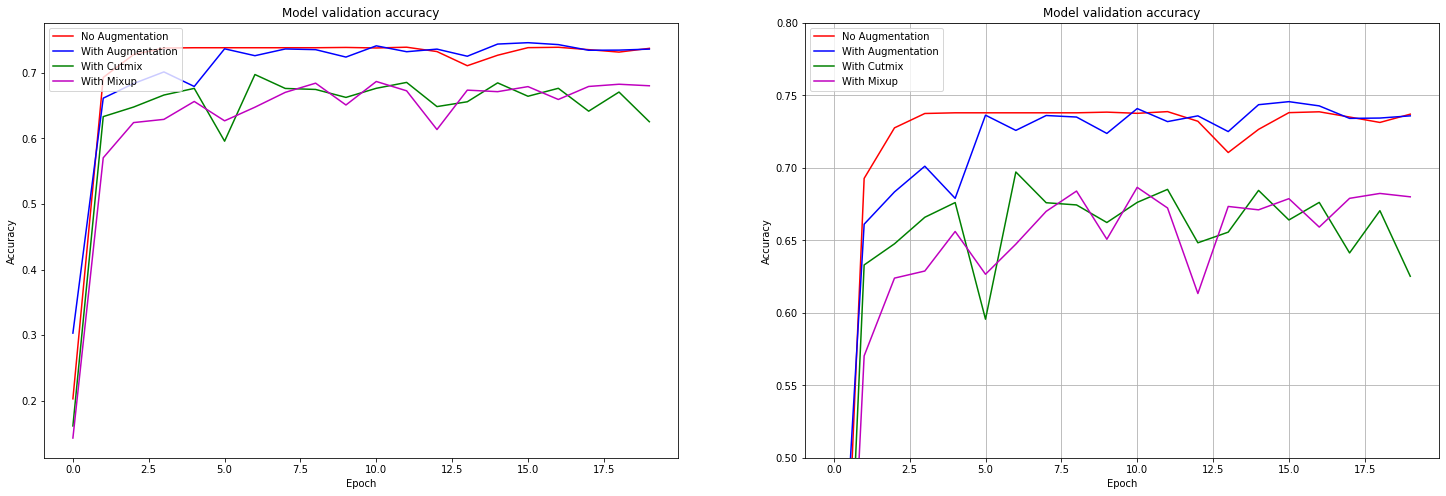

In [27]:
# 훈련 과정 시각화 확대
fig = plt.figure(figsize=(25,8))

plt.subplot(1, 2, 1)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'm')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix', 'With Mixup'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'm')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix', 'With Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)
plt.show()

## 결과
- 기본 augmentation을 한 데이터가 하지 않은 데이터보다 성능이 더 좋음.
- cutmix와 mixup을 한 데이터는 기본 augmentation을 한 데이터나 하지 않은 데이터보다 성능이 더 않좋음.
- augmentation 기법은 데이터의 증강을 위해 하는 것이지 모델의 성능을 높이기 위해 하는 것이 아니기 때문이다.

## 회고
- 각 augmentation 기법들에 대한 함수가 좀 이해하기 어려웠음.
- 전처리 과정에서 에러가 많이 났지만 과정을 조금씩 이해하면서 진행하니 금방 에러를 잡을 수 있었다.